# Academic Article Clustering and Recommendation System

This notebook implements a machine learning pipeline for clustering academic articles and building a content-based recommendation system. The pipeline includes:

1. **Text Preprocessing**: Clean and prepare textual data from academic articles
2. **Feature Engineering**: Create TF-IDF vectors from combined text features
3. **Clustering Analysis**: Apply K-Means clustering to group similar articles
4. **Model Evaluation**: Optimize clustering parameters using elbow method and silhouette analysis
5. **Recommendation System**: Build a KNN-based recommendation system for finding similar articles

## Objectives
- Process and clean academic article text data
- Cluster articles by thematic similarity
- Create an intelligent recommendation system
- Visualize clustering results and patterns

In [35]:
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import numpy as np
import joblib

## 1. Import Required Libraries

Import all necessary libraries for text processing, machine learning, and visualization.

In [ ]:
# Load the cleaned articles dataset
Articles = pd.read_csv('articles_cleaned.csv')
print(f"Loaded {len(Articles)} articles")
print(f"Columns: {list(Articles.columns)}")

## 2. Data Loading and Initial Preparation

Load the cleaned articles dataset from the preprocessing pipeline.

In [37]:
Articles

,title,Auteurs,pub year,author keywords,citations,DOI,abstract,document type,journal name,issn,H-index,scope,quartile,sjr,impact_factor,publisher
0,characterizing land use-land cover changes in ...,"['Salhi, Wiam', 'Heddoun, Ouissal', 'Honnit, B...",2024,"['Deep learning', 'GIS', 'Land use-land cover'...",0,10.1007/s12518-024-00549-8,The examination of changes in land use and lan...,Article,Applied Geomatics,18669298,32.0,Applied Geomatics (AG) is the official journal...,Q2,0.536,2.43,Springer Science and Business Media Deutschlan...
1,a review & analysis of current iot maturity & ...,"['Benotmane, Meryem', 'Elhari, Kaoutar', 'Kabb...",2023,"['Digital transformation', 'Industry 4.0', 'Io...",6,10.1016/j.sciaf.2023.e01748,Internet of Things (IoT) environments are char...,Article•,Scientific African,24682276,36.0,"ScientificAfrican is a peer reviewed, open acc...",Q1,0.575,3.347,Elsevier B.V.
2,hybrid deep learning architecture for land use...,"['Salhi, Wiam', 'Tabiti, Khouloud', 'Honnit, B...",2022,"['Deep learning', 'Image classification', 'Lan...",0,10.14569/IJACSA.2022.01312104,Deep Learning algorithms have become more popu...,Article•,International Journal of Advanced Computer Sci...,2158107X,47.0,Information not localizedJoin the conversation...,Q3,0.278,1.374,Science and Information Organization
3,sentence generation from conceptual graph usin...,"['Bennani, Mohammed', 'Kabbaj, Adil']",2022,"['Conceptual graph', 'Natural language generat...",0,10.1007/978-3-030-94188-8_21,Deep learning (DL) is increasingly used in dif...,Book,Lecture Notes on Data Engineering and Communic...,23674512,30.0,The aim of the book series is to present cutti...,Q3,0.128,0.557,Springer Science and Business Media Deutschlan...
4,survey of iot reference architectures and mode...,"['Benotmane, Meryem', 'Elhari, Kaoutar', 'Kabb...",2022,"['Digital manufacturing', 'Digital transformat...",0,10.1007/978-3-030-89906-6_21,"Nowadays, digital transformation is increasing...",Conference,Lecture Notes in Networks and Systems,23673370,36.0,The series contains proceedings and edited vol...,Q4,0.171,0.575,Springer Science and Business Media Deutschlan...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5056,analysis of the visual lombard effect and auto...,"['Heracleous, Panikos', 'Ishi, Carlos T.', 'Sa...",2013,"['Lip-reading', 'Automatic speech recognition'...",13,10.1016/j.csl.2012.06.003,<p>This study focuses on automatic visual spee...,['Article'],Computer Speech and Language,0885-2308,83,Computer Speech & Language publishes reports o...,Q1,1.05,6.103,Academic Press
5057,<i>step-by-step</i> and <i>integrated</i> appr...,"['Meignier, S', 'Moraru, D', 'Fredouille, C', ...",2006,[],82,10.1016/j.csl.2005.08.002,<p>This paper summarizes the collaboration of ...,"['Article', 'Proceedings Paper']",Computer Speech and Language,0885-2308,83,Computer Speech & Language publishes reports o...,Q1,1.05,6.103,Academic Press
5058,analysis and recognition of nam speech using h...,"['Heracleous, Panikos', 'Tran, Viet-Anh', 'Nag...",2010,"['Audio-visual NAM speech recognition', 'hidde...",12,10.1109/TASL.2009.2037398,<p>Non-audible murmur (NAM) is an unvoiced spe...,['Article'],"IEEE Transactions on Audio, Speech and Languag...",1558-7916,134,"Cessation. IEEE Transactions on Audio, Speech ...",Q1,0.926,0.0,Institute of Electrical and Electronics Engine...
5059,automatic speech recognition for under-resourc...,"['Le, Viet-Bac', 'Besacier, Laurent']",2009,"['Crosslingual acoustic modeling', 'grapheme-b...",64,10.1109/TASL.2009.2021723,<p>This paper presents our work in automatic s...,['Article'],"IEEE Transactions on Audio, Speech and Languag...",1558-7916,134,"Cessation. IEEE Transactions on Audio, Speech ...",Q1,0.926,0.0,Institute of Electrical and Electronics Engine...


In [ ]:
def clean_copyright(text):
    """
    Remove copyright notices and text that appears after © symbol.
    
    Args:
        text (str): Input text to clean
    
    Returns:
        str: Cleaned text without copyright information
    """
    if isinstance(text, str):
        # Remove text starting with © and everything after it
        return re.sub(r'©.*$', '', text).strip()
    return text

# Apply copyright cleaning to abstract column
Articles['abstract'] = Articles['abstract'].apply(clean_copyright)
print("Copyright notices removed from abstracts")

## 3. Text Preprocessing

Clean and prepare textual data for machine learning by removing HTML tags, copyright notices, and standardizing text format.

In [ ]:
# Remove HTML tags from text fields using BeautifulSoup
Articles['abstract'] = Articles['abstract'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
Articles['title'] = Articles['title'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
Articles['journal name'] = Articles['journal name'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
print("HTML tags removed from text fields")

c:\Users\dell\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [ ]:
# Combine all text fields into a single feature for analysis
Articles['combined'] = (Articles['title'] + ' ' + 
                       Articles['abstract'] + ' ' + 
                       Articles['author keywords'] + ' ' + 
                       Articles['journal name'])
print("Text fields combined into 'combined' column")

In [ ]:
def clean_text(text):
    """
    Comprehensive text cleaning function for NLP preprocessing.
    
    Args:
        text (str): Input text to clean
    
    Returns:
        str: Cleaned and normalized text
    """
    if isinstance(text, str):
        # Convert to lowercase for consistency
        text = text.lower()
        
        # Remove special characters and numbers, keep only letters and spaces
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        
        # Tokenize the text into individual words
        tokens = word_tokenize(text)
        
        # Remove stopwords in both English and French
        stop_words = set(stopwords.words('english')).union(set(stopwords.words('french')))
        tokens = [token for token in tokens if token not in stop_words]
        
        # Apply lemmatization to reduce words to their root form
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
        # Join tokens back and clean extra whitespace
        return ' '.join(tokens).strip()
    return text

In [ ]:
# Apply comprehensive text cleaning to the combined text
print("Applying text cleaning (this may take a few minutes)...")
Articles['combined'] = Articles['combined'].apply(clean_text)
print("Text cleaning completed")

In [43]:
Articles.to_csv('articles_cleaned_combined.csv', index=False)

In [ ]:
# Initialize TF-IDF vectorizer with top 1000 features
tfidf = TfidfVectorizer(max_features=1000)

# Transform text data into TF-IDF feature matrix
print("Creating TF-IDF vectors...")
X = tfidf.fit_transform(Articles['combined'])
print(f"TF-IDF matrix shape: {X.shape}")

# Save the vectorizer for future use
joblib.dump(tfidf, 'tfidf.pkl')
print("TF-IDF vectorizer saved as 'tfidf.pkl'")

['tfidf.pkl']

## 4. Feature Engineering

Convert text data into numerical features using TF-IDF vectorization for machine learning analysis.

In [ ]:
# Initialize lists to store clustering metrics
inertia = []  # Within-cluster sum of squared distances
sil_scores = []  # Silhouette scores for each k
k_range = range(2, 20)  # Test cluster numbers from 2 to 19

print("Evaluating clustering performance for different k values...")

# Calculate metrics for each number of clusters
for k in k_range:
    print(f"Testing k={k}...")
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X) 
    inertia.append(kmeans.inertia_) 
    sil_scores.append(silhouette_score(X, kmeans.labels_)) 

print("Clustering evaluation completed")

## 5. Clustering Analysis

Determine the optimal number of clusters using elbow method and silhouette analysis.

In [69]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=('Elbow Method', 'Silhouette Score'))

# Add Elbow plot
fig.add_trace(
    go.Scatter(x=list(k_range), y=inertia, mode='lines+markers', 
               name='Inertia', marker_color='blue'),
    row=1, col=1
)

# Add Silhouette plot
fig.add_trace(
    go.Scatter(x=list(k_range), y=sil_scores, mode='lines+markers',
               name='Silhouette Score', marker_color='red'),
    row=1, col=2
)

# Update layout
fig.update_layout(
    height=500, width=1200,
    showlegend=True,
    title_text="Clustering Metrics"
)

# Update axes labels
fig.update_xaxes(title_text="Number of Clusters (k)")
fig.update_yaxes(title_text="Inertia", row=1, col=1)
fig.update_yaxes(title_text="Silhouette Score", row=1, col=2)

fig.show()

### 5.1 Clustering Metrics Visualization

Visualize elbow method and silhouette scores to determine optimal number of clusters.

In [ ]:
# Apply K-Means clustering with optimal number of clusters
best_k = 6
print(f"Applying K-Means clustering with k={best_k}")

kmeans = KMeans(n_clusters=best_k, init='k-means++', random_state=42)
Articles['cluster'] = kmeans.fit_predict(X)

# Save the trained model
joblib.dump(kmeans, 'kmeans_model.pkl')
print(f"K-Means model saved as 'kmeans_model.pkl'")

# Display cluster distribution
cluster_counts = Articles['cluster'].value_counts().sort_index()
print(f"\nCluster distribution:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} articles")

['kmeans_model.pkl']

### 5.2 Final K-Means Clustering

Apply K-Means clustering with the optimal number of clusters.

In [48]:
from sklearn.decomposition import PCA
import plotly.express as px

# Réduction de la dimensionnalité à 2D avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray()) 

# Création d'un DataFrame pour la visualisation
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['cluster'] = kmeans.labels_  

# Visualisation interactive avec Plotly
fig = px.scatter(
    df_pca,
    x='PCA1',
    y='PCA2',
    color=df_pca['cluster'].astype(str),  
    title='Clusters',
    labels={'cluster': 'Cluster'}
)
fig.show()

In [49]:
Articles[Articles['cluster'] == 3].head(10)

,title,Auteurs,pub year,author keywords,citations,DOI,abstract,document type,journal name,issn,H-index,scope,quartile,sjr,impact_factor,publisher,combined,cluster
127,an investigation of the singular perturbation ...,['Hafidi I.'],2009,[],1,10.1016/j.comcom.2022.04.029,In this article we study the asymptotic behavi...,Article,Differential and Integral Equations,08934983,31.0,Differential and Integral Equations will publi...,Q2,0.79,1.8,Texas State University - San Marcos,investigation singular perturbation problem co...,3
128,analysis of a parabolic compressible first-ord...,"['Ciuperca I.', 'Hafidi I.', 'Jai M.']",1234,"['Compressible Reynolds equation', 'Parabolic ...",1,10.1016/j.na.2006.08.054,We study a lubricated system consisting of two...,Article,"Nonlinear Analysis, Theory, Methods and Applic...",0362546X,136.0,Nonlinear Analysis aims at publishing high qua...,Q1,1.278,1.457,Elsevier Ltd,analysis parabolic compressible first order sl...,3
129,existence of equilibria in articulated bearing...,"['Buscaglia G.', 'Ciuperca I.', 'Hafidi I.', '...",2007,"['Equilibrium', 'Lubrication', 'Reynolds varia...",4,10.1016/j.jmaa.2007.01.074,The existence of equilibrium solutions for a l...,Article,Journal of Mathematical Analysis and Applications,0022247X,162.0,The Journal of Mathematical Analysis and Appli...,Q2,0.816,1.396,Academic Press Inc.,existence equilibrium articulated bearing pres...,3
140,existence of solution for kirchhoff type probl...,"['Sbai, Abdelaaziz', 'El Hadfi, Youssef', 'Sra...",2022,"['Existence', 'Kirchhoff type problem', ""Leray...",1,10.3934/dcdss.2021015,"In this paper, we establish the existence of w...",Article•,Discrete and Continuous Dynamical Systems - Se...,19371632,40.0,No Scope,Q2,0.541,1.591,American Institute of Mathematical Sciences,existence solution kirchhoff type problem orli...,3
153,an inverse problem of identifying two coeffici...,"['Srati, Mohammed', 'Oulmelk, Abdessamad', 'Af...",2025,"['inverse parameter problem', 'optimal control...",1,10.3934/dcdss.2023054,"In this paper, we aim to study an inverse prob...",Article,Discrete and Continuous Dynamical Systems - Se...,19371632,40.0,No Scope,Q2,0.541,1.591,American Institute of Mathematical Sciences,inverse problem identifying two coefficient ti...,3
154,implementation of the admm approach to constra...,"['Oulmelk, Abdessamad', 'Srati, Mohammed', 'Af...",2025,"['ADMM method', 'convergence analysis', 'inver...",3,10.3934/dcdss.2022194,"In this paper, we study the inverse problem of...",Article,Discrete and Continuous Dynamical Systems - Se...,19371632,40.0,No Scope,Q2,0.541,1.591,American Institute of Mathematical Sciences,implementation admm approach constrained optim...,3
156,shape reconstruction for advection-diffusion p...,"['Cherrat, Elmehdi', 'Afraites, Lekbir', 'Raba...",2025,"['Advection-diffusion problem', 'geometric inv...",1,10.3934/dcdss.2023186,We consider the inverse problem of identifying...,Article,Discrete and Continuous Dynamical Systems - Se...,19371632,40.0,No Scope,Q2,0.541,1.591,American Institute of Mathematical Sciences,shape reconstruction advection diffusion probl...,3
157,nonsmooth optimization method for determining ...,"['Oulmelk A.', 'Afraites L.', 'Hadri A.', 'Zak...",2025,"['Control optimal problem', 'Inverse problem',...",0,10.1016/j.cnsns.2024.108437,A determination of the nonsmooth potential par...,Article,Communications in Nonlinear Science and Numeri...,10075704,137.0,No Scope,Q1,0.919,3.864,Elsevier B.V.,nonsmooth optimization method determining nons...,3
166,alternating direction multiplier method to est...,"['Oulmelk A.', 'Afraites L.', 'Hadri A.', 'Zak...",2024,['Alternating direction method of multipliers'...,3,10.1016/j.camwa.2023.12.027,An estimation for the unknown source term in t...,Article,Computers and Mathematics with Applications,08981221,154.0,No Scope,Q1,0.949,3.084,Elsevier Ltd,alternating direction multiplier method estima...,3
167,an inverse problem of determining the paramete...,"['Sr

<strong>DBSCAN</strong>

In [50]:
Articles[Articles['cluster'] == 4].head(10)

,title,Auteurs,pub year,author keywords,citations,DOI,abstract,document type,journal name,issn,H-index,scope,quartile,sjr,impact_factor,publisher,combined,cluster
9,ontologies in amine platform: structures and p...,"['Kabbaj, Adil', 'Bouzouba, Karim', 'El Hachim...",313,[],17,10.1007/11787181_22,The theoretical part of this paper presents an...,Conference,Lecture Notes in Computer Science,03029743,470.0,This distinguished conference proceedings seri...,Q2,0.606,1.09,Springer Verlag,ontology amine platform structure process theo...,4
17,artificial intelligence for assessing the plan...,"['Moudden, Tarik El', 'Amnai, Mohamed', 'Chouk...",2024,"['Artificial neural network', 'Comets', 'Earth...",0,10.1016/j.jog.2024.102057,Questions about interconnection possibilities ...,Article,Journal of Geodynamics,02643707,87.0,No Scope,Q2,0.751,2.161,Elsevier Ltd,artificial intelligence assessing planet posit...,4
22,engineering education using serious games: the...,"['Sabri, Zineb', 'Remaida, Ahmed', 'Benyoussef...",127,"['Bibliometrics', 'Covid-19', 'Employability',...",1,10.1007/978-981-97-0126-1_11,There is a global concern about using serious ...,Conference,Lecture Notes in Electrical Engineering,18761100,45.0,No Scope,Q4,0.147,0.376,Springer Verlag,engineering education using serious game curre...,4
27,what factors determine the academic orientatio...,"['Sellamy, Khadija', 'Fakhri, Youssef', 'Moume...",2023,"['academic orientation', 'job market requireme...",5,10.3390/su15086866,Guidance is a dynamic process that takes place...,Article•,Sustainability,20711050,169.0,No Scope,Q2,0.672,3.953,Multidisciplinary Digital Publishing Institute...,factor determine academic orientation moroccan...,4
44,bond graph model - intelligent online diagnost...,"['Ezzaki, Mustapha', 'Fakhri, Youssef', 'Ennim...",4435,"['Bond graph', 'Diagnosis', 'Education', 'Impl...",2,No DOI,"Nowadays, the control of physical systems is t...",Article,Journal of Theoretical and Applied Information...,19928645,39.0,No Scope,Q4,0.174,0.756,Little Lion Scientific,bond graph model intelligent online diagnostic...,4
48,toward increasing and investigating e-tourism ...,"['Bourekkadi S.', 'Slimani K.', 'Imrani O.E.L....",3232,"['Data Warehouse', 'E-Tourism', 'Five Analysis...",6,No DOI,"Nowadays, the competition between companies of...",Article,Journal of Theoretical and Applied Information...,19928645,39.0,No Scope,Q4,0.174,0.756,Little Lion Scientific,toward increasing investigating e tourism data...,4
49,a geometrically constrained manifold embedding...,"['Deregnaucourt, Thomas', 'Samir, Chafik', 'El...",2020,"['Covariance operator', 'Gaussian process', 'R...",0,10.1007/978-3-030-35202-8_5,We introduce a new framework of local and adap...,Book,Applied and Numerical Harmonic Analysis,22965009,28.0,No Scope,Q4,0.131,0.243,Springer International Publishing AG,geometrically constrained manifold embedding e...,4
59,jeutice: an arabic serious game to enhance mat...,"['Tazouti, Yassine', 'Boulaknadel, Siham', 'Fa...",2019,"['Educational game', 'Game learning', 'Game-ba...",8,10.3991/ijet.v14i22.11119,Serious games have become a much-discussed tre...,Article•,International Journal of Emerging Technologies...,18688799,46.0,No Scope,Q2,0.536,2.33,International Association of Online Engineering,jeutice arabic serious game enhance mathematic...,4
62,video sensor node energy preservation through ...,"['Alaoui-Fdili, Othmane', 'Coudoux, François-X...",2018,"['Adaptive video encoding', 'Energy consumptio...",2,10.1016/j.suscom.2018.02.006,Wireless video sensor networks (WVSN) are ener...,Article•,Sustainable Computing: Informatics and Systems,22105379,47.0,No Scope,Q1,1.014,5.431,Elsevier Inc.,video sensor node energy preservation dynamic ...,4
85,downlink throughput maximization in multicarri...,"['Fakhri, Youssef', 'Vidal, Josep', 'Aboutajdi...",1327,"['Average throughput', 'OFDM', 'Packet success...",1,No DOI,In this paper we present a mathematical techni...,Article,WSEAS Transactions o

In [51]:
from sklearn.metrics.pairwise import euclidean_distances

def euclidean_similarity(text1, text2, tfidf_vectorizer):
    tfidf1 = tfidf_vectorizer.transform([text1])
    tfidf2 = tfidf_vectorizer.transform([text2])
    distance = euclidean_distances(tfidf1, tfidf2)
    return 1 / (1 + distance[0][0])  # Similarity is the inverse of distance


In [52]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
def predict_knn(title, abstract, keywords, tokenizer_path, model_path, Articles, k=10):
    """
    Predict similar articles using K-Nearest Neighbors within the same cluster.
    
    Args:
        title (str): Article title
        abstract (str): Article abstract
        keywords (str): Article keywords
        tokenizer_path (str): Path to saved TF-IDF vectorizer
        model_path (str): Path to saved K-Means model
        Articles (DataFrame): Articles dataset with clusters
        k (int): Number of similar articles to return
    
    Returns:
        DataFrame: Similar articles sorted by similarity score
    """
    from sklearn.neighbors import NearestNeighbors
    
    # Load pre-trained models
    tfidf = joblib.load(tokenizer_path)
    model = joblib.load(model_path)
    
    # Combine and clean input text
    input_text = title + ' ' + abstract + ' ' + keywords
    text = clean_text(input_text)
    text_vector = tfidf.transform([text])
    
    # Predict cluster for the input article
    cluster = model.predict(text_vector)
    print(f"Predicted cluster: {cluster[0]}")
    
    # Filter articles from the same cluster
    cluster_articles = pd.DataFrame(Articles[Articles["cluster"] == cluster[0]])
    print(f"Articles in cluster {cluster[0]}: {len(cluster_articles)}")

    if 'combined' in cluster_articles.columns:
        # Transform cluster articles to TF-IDF vectors
        article_vectors = tfidf.transform(cluster_articles['combined'])
        
        # Find k nearest neighbors using cosine similarity
        knn = NearestNeighbors(n_neighbors=min(k, len(cluster_articles)), metric='cosine')
        knn.fit(article_vectors)
        distances, indices = knn.kneighbors(text_vector)
        
        # Get similar articles and add distance scores
        similar_articles = cluster_articles.iloc[indices[0]].copy()
        similar_articles['similarity_score'] = 1 - distances[0]  # Convert distance to similarity
        
        return similar_articles.sort_values(by='similarity_score', ascending=False)
    
    return pd.DataFrame()

## 6. Recommendation System

Build a content-based recommendation system using K-Nearest Neighbors for finding similar articles.

In [ ]:
# Define a test article for recommendation system
title = "Enhanced DGA detection in Botnet traffic: leveraging N-Gram, topic modeling, and attention BiLSTM"

abstract = """This abstract introduces a novel approach for detecting Domain Generation Algorithms (DGA) in Botnet traffic through the integration of N-Gram analysis, Topic Modeling, and Attention-based Bidirectional Long Short-Term Memory (BiLSTM) networks. The proposed model begins with N-Gram analysis to capture sequential patterns in domain names, enhancing the detection of algorithmically generated domains. Topic Modeling extracts latent themes within network traffic data, providing a deeper understanding of the semantic context associated with potentially malicious domains. An Attention mechanism is integrated into a BiLSTM network to harness contextual nuances, allowing the model to selectively focus on critical segments of the input data. This attention-driven BiLSTM network captures long-range dependencies and intricate temporal dynamics inherent in Botnet communication. Experimental evaluations on diverse datasets demonstrate the proposed approach's efficacy in outperforming existing methods. The HybridNATT-DGA model achieved an accuracy of 99% using the Adam optimizer, surpassing the performance of other models such as LSTM (97.64%), ATT-CNN-B (94%), and ANN (95%). Additionally, the model exhibited a validation accuracy of 98% and a validation loss of 0.02, highlighting its robustness and precision. These results underscore the model's ability to adapt to evolving adversarial strategies, showcasing its superior detection rates. The fusion of N-Gram analysis, Topic Modeling, and Attention BiLSTM offers a comprehensive solution for DGA detection, providing a robust defense against sophisticated cyber threats in the continually evolving landscape of network security. This research advances the field of intrusion detection and cyber threat mitigation by presenting a holistic and adaptive approach tailored to the challenges posed by modern Botnet traffic."""

keywords = "And Bidirectional Long Short-Term Memory (BiLSTM); Botnet traffic; Domain Generation Algorithm (DGA); N-Gram analysis; Topic modeling"

print("Test article defined for recommendation system")

### 6.1 Test the Recommendation System

Test the recommendation system with a sample article to find similar research papers.

In [ ]:
# Get recommendations for the test article
print("Finding similar articles...")
recommendations = predict_knn(
    title=title,
    abstract=abstract,
    keywords=keywords,
    tokenizer_path='tfidf.pkl',
    model_path='kmeans_model.pkl',
    Articles=Articles, 
    k=10
)

print(f"\nFound {len(recommendations)} similar articles")
print("\nTop 5 recommended articles:")
for i, (idx, row) in enumerate(recommendations.head().iterrows()):
    print(f"{i+1}. {row['title'][:100]}... (Similarity: {row['similarity_score']:.3f})")

C:\Users\dell\AppData\Local\Temp\ipykernel_10624\1575892408.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [56]:
"Application of Unsupervised Learning in Detecting Behavioral Patterns in E-commerce Customers",

('Application of Unsupervised Learning in Detecting Behavioral Patterns in E-commerce Customers',)

In [95]:
for i in df['journal name']:
    print(i)

Multimedia Tools and Applications
Applied Sciences (Switzerland)
IAES International Journal of Artificial Intelligence
Big Data
Advanced Sciences and Technologies for Security Applications
IEEE Transactions on Engineering Management
Applied Sciences (Switzerland)
IEEE Transactions on Intelligent Transportation Systems
Advanced Sciences and Technologies for Security Applications
Computer Communications


In [96]:
for i in df['title']:
    print(i)

convolutional neural network based early fire detection
target detection and recognition for traffic congestion in smart cities using deep learning-enabled uavs: a review and analysis
unified and evolved approach based on neural network and deep learning methods for intrusion detection
ielmnet: integrating novel improved extreme learning machine and convolutional neural network model for traffic sign detection
dbd: deep learning dga-based botnet detection
adversarial defense: dga-based botnets and dns homographs detection through integrated deep learning
an adaptive multi-layer botnet detection technique using machine learning classifiers
a vision transformer approach for traffic congestion prediction in urban areas
enhanced domain generating algorithm detection based on deep neural networks
sdn-based real-time urban traffic analysis in vanet environment


In [58]:
"A MULTI-AGENT BASED SOCIAL CRM FRAMEWORK FOR EXTRACTING AND ANALYSING OPINIONS".lower()


'a multi-agent based social crm framework for extracting and analysing opinions'

In [59]:
from rapidfuzz.fuzz import ratio
def similarity_score(string1, string2):
    # Calculate similarity score using rapidfuzz
    return ratio(string1, string2) / 100.0  # Normalize to 0-1 scale


In [ ]:
# Save the final clustered articles dataset
Articles.to_csv('Articles_clustered.csv', index=False)
print("Clustered articles saved as 'Articles_clustered.csv'")
print(f"Total articles: {len(Articles)}")
print(f"Number of clusters: {Articles['cluster'].nunique()}")

## 7. Save Final Results

Save the clustered articles dataset and visualize cluster characteristics.

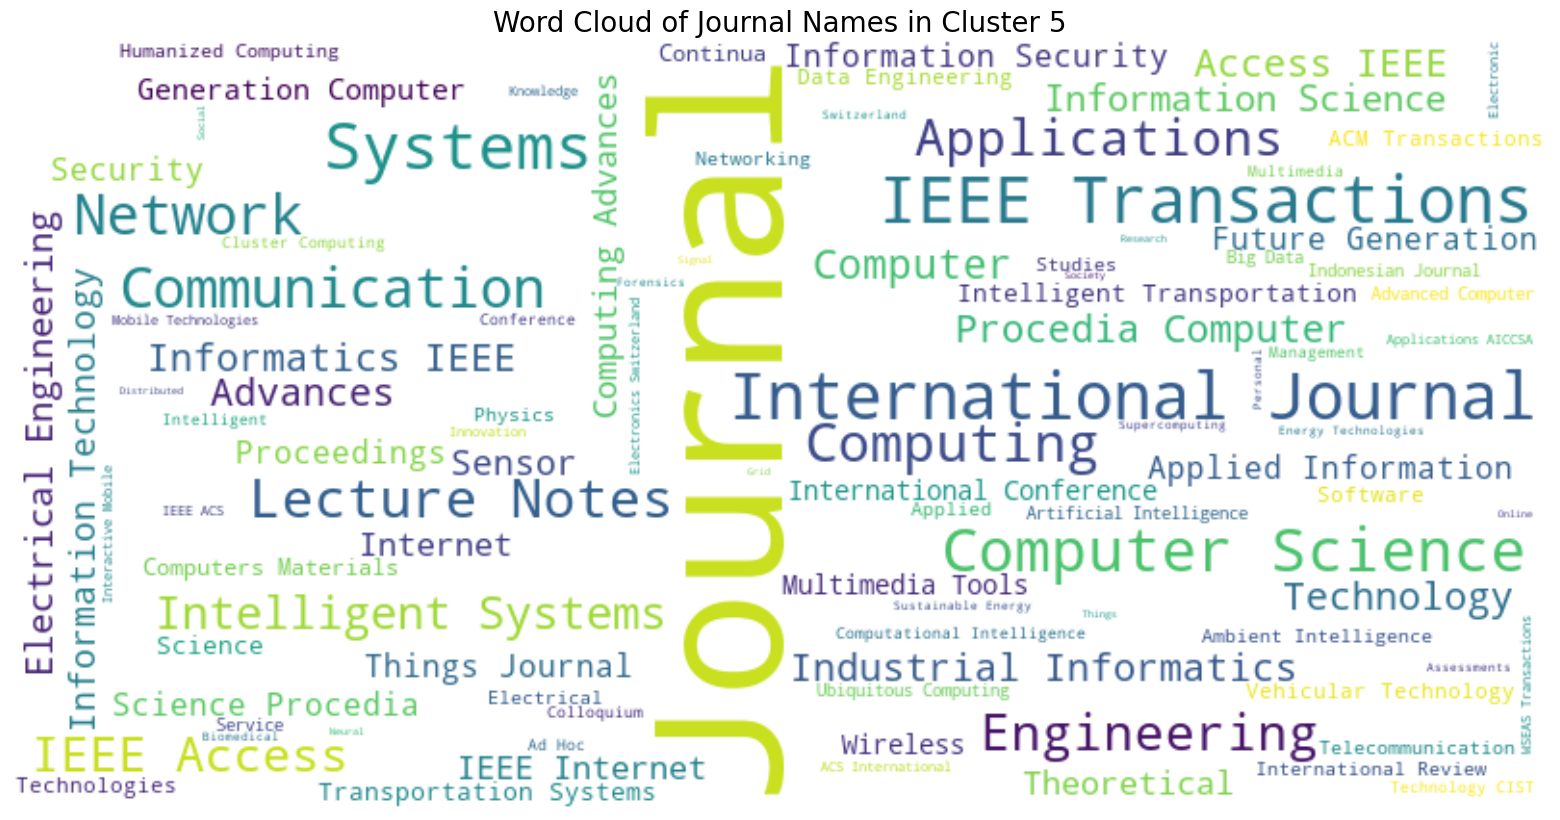

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud for a specific cluster to understand its themes
cluster_id = 5
print(f"Generating word cloud for Cluster {cluster_id}")

# Get journal names from the specified cluster and combine into single text
cluster_articles = Articles[Articles['cluster'] == cluster_id]
text = ' '.join(cluster_articles['journal name'].astype(str))

print(f"Cluster {cluster_id} contains {len(cluster_articles)} articles")

# Generate and display word cloud
wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='white',
    max_words=100,
    contour_width=3,
    contour_color='steelblue'
).generate(text)

# Display the word cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Word Cloud of Journal Names in Cluster {cluster_id}', fontsize=20)
plt.show()

### 7.1 Cluster Visualization

Generate word clouds to visualize the characteristics of different clusters.

In [ ]:
## 8. Conclusion

This notebook has successfully implemented a complete machine learning pipeline for academic article analysis:

### Key Achievements:
1. **Text Preprocessing**: Cleaned and standardized textual data from academic articles
2. **Feature Engineering**: Created TF-IDF vectors representing article content
3. **Clustering Analysis**: Applied K-Means clustering to group articles by similarity
4. **Model Optimization**: Used elbow method and silhouette analysis to find optimal clusters
5. **Recommendation System**: Built a KNN-based system for finding similar articles
6. **Visualization**: Created word clouds to understand cluster characteristics

### Outputs Generated:
- `Articles_clustered.csv`: Final dataset with cluster assignments
- `tfidf.pkl`: Trained TF-IDF vectorizer for text processing
- `kmeans_model.pkl`: Trained K-Means clustering model
- Interactive visualizations of clustering results

### Next Steps:
- Test the recommendation system with different articles
- Analyze cluster characteristics in more detail
- Implement additional similarity metrics
- Deploy the recommendation system as a web application